In [300]:
import pandas_ta as ta
import pandas as pd
import yfinance as yf
import mplfinance as mpf

In [301]:
df = pd.DataFrame().ta.ticker("TSLA")

c:\Users\Arnas Vaicekauskas\AppData\Local\Programs\Python\Python312\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [302]:
short_window = 10
long_window = 20

df['sma-short'] = df['Close'].rolling(window=short_window).mean()
df['sma-long'] = df['Close'].rolling(window=long_window).mean()

df['signal'] = 0
df.loc[df['sma-short'] > df['sma-long'], 'signal'] = 1
df.loc[df['sma-short'] < df['sma-long'], 'signal'] = -1

df['dsignal'] = df['signal'].diff()

In [303]:
# take some interval
start_date, end_date = '2023-01-01', '2023-12-31'

df = df[df.index >= start_date]
df = df[df.index <= end_date]

In [304]:
offset = 10

# zero everywhere, except where buy action happened
df['buy_action'] = None
df.loc[df['dsignal'] > 0, 'buy_action'] = df['sma-short']

# zero everywhere, except where sell action happened
df['sell_action'] = None
df.loc[df['dsignal'] < 0, 'sell_action'] = df['sma-short']

In [305]:
take_profit = 300
stop_loss = 100

In [306]:
df['stop_loss'] = stop_loss
df['take_profit'] = take_profit

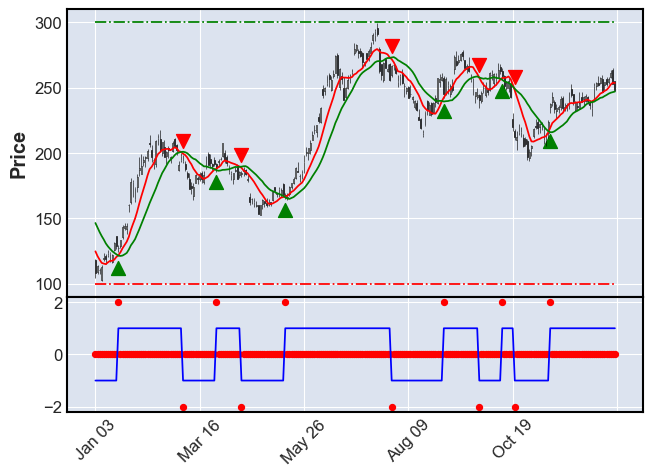

In [307]:
apds = [
    mpf.make_addplot(df['stop_loss'], color='r', linestyle='-.'),
    mpf.make_addplot(df['take_profit'], color='g', linestyle='-.'),
    mpf.make_addplot(df['buy_action'] - offset, type='scatter', panel=0, secondary_y=False, markersize=100, marker='^', color = 'green'),
    mpf.make_addplot(df['sell_action'] + offset, type='scatter', panel=0, secondary_y=False, markersize=100, marker='v', color = 'red'),
    mpf.make_addplot(df['dsignal'], type='scatter', panel=1, color='r', secondary_y=False),
    mpf.make_addplot(df['sma-short'], panel=0, color='r', secondary_y=False),
    mpf.make_addplot(df['sma-long'], panel=0, color='g', secondary_y=False),
    mpf.make_addplot(df['signal'], panel=1, color='b', secondary_y=False)
]

mpf.plot(df, type='candle', addplot=apds, volume=False)

In [308]:
def sell(date, balance, position, current_price, trade_fee, df):
    total = (1 - trade_fee) * position * current_price
    print(f'Sell {position:.2f} stock at {current_price:.2f} per stock (total: {total:.2f}, fee: {trade_fee * position * current_price})')

    df.loc[date, 'dbalance'] = total

    balance += total

    df.loc[date, 'dposition'] = -position

    position = 0
    df.loc[date, 'dfee'] = trade_fee * position * current_price

    return (balance, position)
    

def buy(date, balance, position, current_price, trade_fee, df):
    amount = balance // ((1 + trade_fee) * current_price)
    total = (1 + trade_fee) * amount * current_price
    print(f'Buy {amount:.2f} stock at {current_price:.2f} per stock (total: {total:.2f}, fee: {trade_fee * amount * current_price})')
    position += amount
    balance -= total

    df.loc[date, 'dbalance'] = -total
    df.loc[date, 'dfee'] = trade_fee * amount * current_price
    df.loc[date, 'dposition'] = amount

    return (balance, position)
    

In [309]:
df['dbalance'] = 0.0
df['dfee'] = 0.0
df['dposition'] = 0.0

trade_fee = 0.02
starting_balance = 1000
balance = starting_balance # money units
position = 0 # stock units

for date, signal in zip(df.index, df['dsignal']):

    current_price = df['Close'][date]

    # calculate profit at time t
    if(current_price <= stop_loss or current_price >= take_profit):
 
        # sell & stop trading
        print('[stop loss]') if current_price <= stop_loss else print('[take profit]')
        balance, position = sell(date, balance, position, current_price, trade_fee, df)
        break

    if(signal == 0):
        continue

    print(f'[pos: {position}, bal: {balance}]')

    if(signal > 0): # buy
        balance, position = buy(date, balance, position, current_price, trade_fee, df)
    
    else: # sell
        balance, position = sell(date, balance, position, current_price, trade_fee, df)

# after simulation sell everything for last known price
print(f'[pos: {position}, bal: {balance}]')
balance, position = sell(date, balance, position, df['Close'][-1], trade_fee, df)
print(f'[pos: {position}, bal: {balance}]')

# the money I spent: fees + accumulated buy-in prices

# formula for profit if im holding a postion?
# (1 - fee) * position * price
print(f'profit: {balance - starting_balance:.2f}')

print(f'min price: {df['Close'].min():.2f}')
print(f'max price: {df['Close'].max():.2f}')

[pos: 0, bal: 1000]
Buy 7.00 stock at 127.17 per stock (total: 907.99, fee: 17.803799743652345)
[pos: 7.0, bal: 92.00621307373035]
Sell 7.00 stock at 193.81 per stock (total: 1329.54, fee: 27.13339965820313)
[pos: 0, bal: 1421.5427963256834]
Buy 7.00 stock at 189.19 per stock (total: 1350.82, fee: 26.486600341796876)
[pos: 7.0, bal: 70.72617889404273]
Sell 7.00 stock at 185.00 per stock (total: 1269.10, fee: 25.900000000000002)
[pos: 0, bal: 1339.8261788940426]
Buy 7.00 stock at 166.35 per stock (total: 1187.74, fee: 23.28900085449219)
[pos: 7.0, bal: 152.08713531494095]
Sell 7.00 stock at 266.44 per stock (total: 1827.78, fee: 37.30160034179688)
[pos: 0, bal: 1979.8655520629877]
Buy 7.00 stock at 245.01 per stock (total: 1749.37, fee: 34.30139923095703)
[pos: 7.0, bal: 230.4941912841789]
Sell 7.00 stock at 240.50 per stock (total: 1649.83, fee: 33.67)
[pos: 0, bal: 1880.3241912841788]
Buy 7.00 stock at 258.87 per stock (total: 1848.33, fee: 36.24179931640625)
[pos: 7.0, bal: 31.992426

C:\Users\Arnas Vaicekauskas\AppData\Local\Temp\ipykernel_24188\2482220946.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  balance, position = sell(date, balance, position, df['Close'][-1], trade_fee, df)


C:\Users\Arnas Vaicekauskas\AppData\Local\Temp\ipykernel_24188\861683911.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '890.1899871826172' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[date, 'buy-in_intervals'] = interval_value


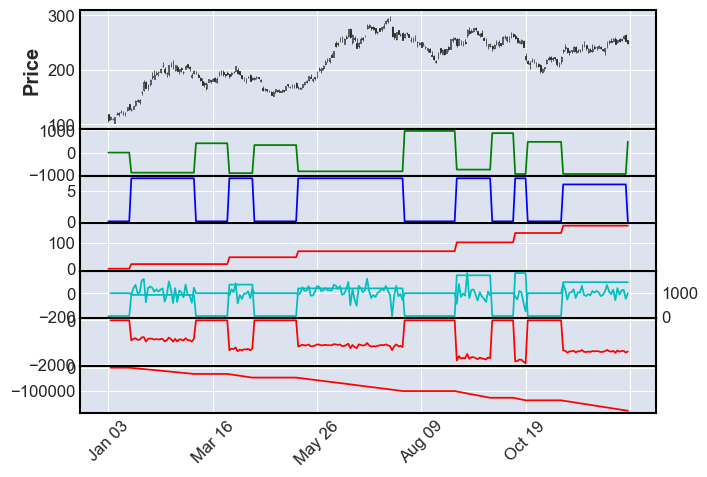

In [314]:

df['pos'] = df['dposition'].cumsum()
df['fee'] = df['dfee'].cumsum()
df['bal'] = df['dbalance'].cumsum()

# adjusted values -1 to 1 -> 0 to 1
# this can be used as a mask
adjusted_sig = (df['signal'] + 1) / 2

# worth of position at time t
# 0 if not bought it
# intervals begin with buy-in price and evolve until buy-out
df['masked_close'] = adjusted_sig * df['Close'] * df['pos']

# Change of position value over time (no change when not bought-in)
dclose = df['Close'].diff()
df['dposval'] = adjusted_sig * dclose * df['pos']

# price of stocks I bought at time t
buy_signals = df['dsignal'].apply(lambda x: max(x, 0))
df['buy_price'] = buy_signals * df['Close'] * df['pos']

# price of stocks I sold at time t
sell_signals = df['dsignal'].apply(lambda x: min(x, 0))
df['sell_price'] = sell_signals * df['Close'] * df['pos']

# buy and sell price are offset


# intervals that have value of buy-in cost
df['buy-in_intervals'] = 0

in_interval = False
interval_value = 0

for date, row in df.iterrows():
    
    ds = row['dsignal']

    # we're already in the interval
    if in_interval:
        # we exited the interval
        if ds < 0:
            in_interval = False
        # set values
        else:
            df.loc[date, 'buy-in_intervals'] = interval_value
    # we're not in an interval
    else:
        # we entered an interval
        if ds > 0:
            in_interval = True
            interval_value = df['pos'][date] * df['Close'][date]
            df.loc[date, 'buy-in_intervals'] = interval_value

df['dprofit'] = df['dposval'] - df['buy-in_intervals'] - df['dfee']

apds = [
    mpf.make_addplot(df['fee'], panel=3, color='r'),
    mpf.make_addplot(df['bal'], panel=1, color='g'),
    mpf.make_addplot(df['pos'], panel=2, color='b'),
    mpf.make_addplot(df['dposval'], panel=4, color='c'),
    mpf.make_addplot(df['buy-in_intervals'], panel=4, color='c'),
    mpf.make_addplot(df['dprofit'], panel=5, color='r'),
    mpf.make_addplot(df['dprofit'].cumsum(), panel=6, color='r'),
]

mpf.plot(df, type='candle', addplot=apds, volume=False)

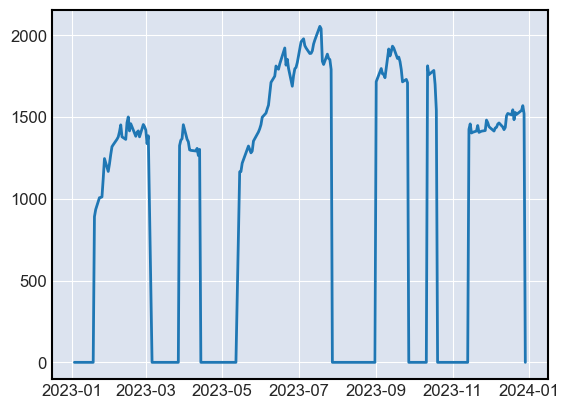

In [312]:
import matplotlib.pyplot as plt

plt.plot(df['masked_close'])